<a href="https://colab.research.google.com/github/Zomma2/Regression-with-tensorflow/blob/master/TensorFlow_Beginner_Predicting_House_Prices_with_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline


## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [3]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [4]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [5]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [6]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [7]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [8]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [9]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [11]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.0282 - val_loss: 0.8874
Epoch 2/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0276 - val_loss: 0.8869
Epoch 3/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0271 - val_loss: 0.8864
Epoch 4/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0266 - val_loss: 0.8860
Epoch 5/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0261 - val_loss: 0.8856
Epoch 6/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0256 - val_loss: 0.8852
Epoch 7/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0251 - val_loss: 0.8847
Epoch 8/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0247 - val_loss: 0.8843
Epoch 9/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0242 - val_loss: 0.8839
Epoch 10/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.023

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

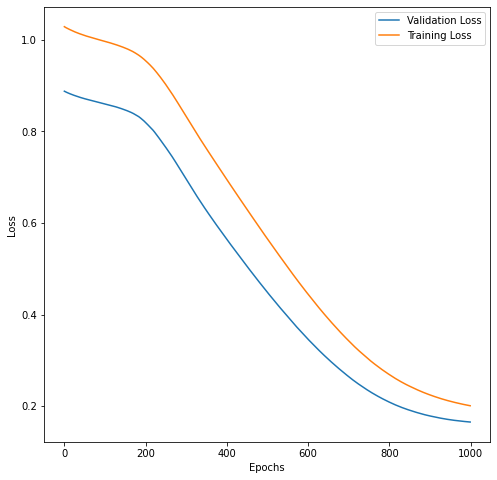

In [13]:
plot_loss(history)

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

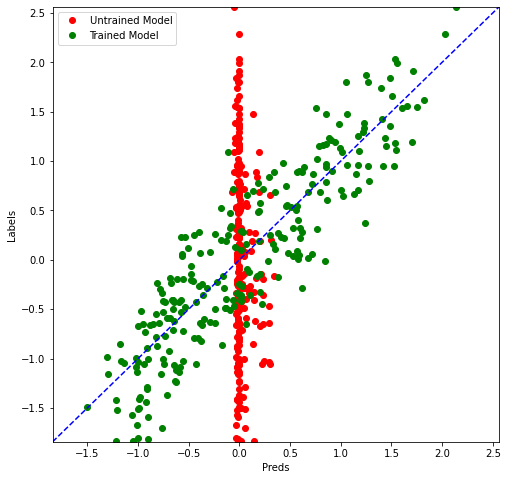

In [14]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

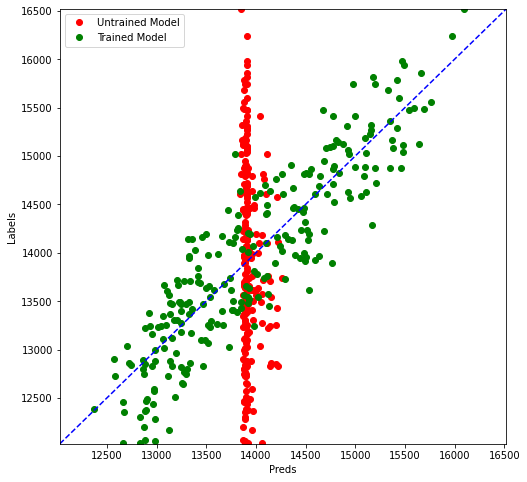

In [15]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)